## Libraries

In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/injy/mariam_workspace/env/lib/python3.5/site-pack

In [3]:
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import sys
sys.path.insert(0, '../.')
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
from evaluation.evaluate import *
from data.postprocessing.nms import *
from data.data_utils.reader_utils import *

In [4]:
tf.__version__

'1.14.0'

## Utils

In [5]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    ratio = 1
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :,  -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
#             print('x = ', x, "y = ", y)
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])

#             mins = np.array([-0.5, -0.5, 0, 0.7, 0.1, 0.1, -1.1, -1.1])
#             maxs = np.array([0.5, 0.5, 1, 1.9, 0.75, 0.91, 1.1, 1.1])
        
#             out[:8] = ((out[:8] + 1) / 2) * (maxs - mins) + mins
#             out[:2] = out[:2][::-1]
#             if truth_value is not None:
#                 print('gt = ', truth_value[ones_index[0][i], ones_index[1][i], :3])
#             print('out[:3] = ', out[:3])
            out[:3] = np.exp(out[:3]) * anchors
#             print('exp(out[:3]) = ', out[:3])
    
            out[:3] = out[:3] + anchor[:3]
#             print('out[:3] anch = ', out[:3])
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 35
            
#             print('final out[:3] = ', out[:3])
            
            
            
#             out[6] = np.arctan2(out[6], out[7])
                        
            result.append(out)
            
    return np.array(result)

In [6]:
import numpy as np
from PIL import Image, ImageDraw
import math
import numpy.matlib as npm

def convert5Pointto8Point(cx_, cy_, w_, h_, a_):

    theta = math.radians(a_)
    bbox = npm.repmat([[cx_], [cy_]], 1, 5) + \
       np.matmul([[math.cos(theta), math.sin(theta)],
                  [-math.sin(theta), math.cos(theta)]],
                 [[-w_ / 2, w_/ 2, w_ / 2, -w_ / 2, w_ / 2 + 8],
                  [-h_ / 2, -h_ / 2, h_ / 2, h_ / 2, 0]])
    x1, y1 = bbox[0][0], bbox[1][0]
    x2, y2 = bbox[0][1], bbox[1][1]
    x3, y3 = bbox[0][2], bbox[1][2]
    x4, y4 = bbox[0][3], bbox[1][3]

    return [x1, y1, x2, y2, x3, y3, x4, y4]

In [7]:
def get_points(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448, 512, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = np.arctan2(converted_points_[6], converted_points_[7])
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size          

#             print(converted_points_[:3])
#             converted_points_[0] = 179.55859811597736
#             converted_points_[1] = 276.6431893013815
#             , 206.281385562958]
#             print(converted_points_[:3])
            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
#             print('point')
#             print(point)
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
#             print('pts_3d_ref')
#             print(pts_3d_ref)
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

## Evaluation

In [8]:
def read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 35), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False, fliplr=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            # lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car', 'Van', 'Truck', 'Tram']), lines))
             lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    directions = np.array(angles>= 0).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations.shape)
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo2(rot, tr, sc, locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # if len(locations) > 0 and len(locations[0]) > 0:
    #     locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations.shape)
    # print(z_range)
    # print(locations)

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
    
    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]
        directions = directions[indx]

    points = [project_point_from_camera_coor_to_velo_coor2(rot, tr, sc, [location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    # points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
    #                                                     [dimension_height[i], dimension_width[i], dimension_length[i]],
    #                                                     angles[i],
    #                                                      calib_data)
    #             for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size

    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#         if angles[i] < 0:
#             angles[i] += 3.14

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # output = [[locations[i][0], locations[i][1], locations[i][2], 
    #             dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
    #             for i in range(len(locations))]
    # import math
    if fliplr:
        for i in range(len(locations)):
            h = size[1]
            output[i][1] = h - output[i][1]

    if ang != 0:
        for i in range(len(locations)):
            # w = size[0]
            # h = size[1]
            # output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2'], directions


In [9]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                    size=(448, 512, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, translate_z=0, ang=0, get_neg=False):

    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path, 'r') as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = np.array(get_parameter(0))
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
    # print(locations)
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
    # print(locations)
    # print(z_range)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

    indx = []
    i = 0
    for point in locations:
        if (point[0] >= x_range[0]  and point[0] <= x_range[1])\
            and (point[1] >= y_range[0] and point[1] <= y_range[1])\
            and (point[2] >= z_range[0] and point[2] <= z_range[1]):
            indx.append(i)
        i += 1

    if len(indx) > 0:
        dimension_height = dimension_height[indx]
        dimension_width = dimension_width[indx]
        dimension_length = dimension_length[indx]
        location_x = location_x[indx]
        location_y = location_y[indx]
        location_z = location_z[indx]
        angles = angles[indx]
        classes = classes[indx]

    if len(locations) > 0:
        locations[:, :3] = locations[:, :3] - np.array([translate_x, translate_y, -translate_z])

    # print('.......')
    # print(len(locations))

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 35) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 35) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 35) * y_fac + size[1]
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)

      
#     for i in range(len(locations)):
#             if angles[i] < 0:
#                 angles[i] += np.pi

    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    z_range = (z_range[0] + translate_z, z_range[1] + translate_z)
    output = [[-(locations[i][0] + -1*x_range[0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_height[i], dimension_width[i], dimension_length[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = list(filter(lambda point: 0 <= point[0] < size[0] and 0 <= point[1] < size[1] and 0 <= point[2] < size[2] , output))
    output = np.array(output)

    return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']




In [10]:
base_path = '../../../Data'

In [11]:
def get_augmentation_parameters(augment):
        # if self.augment:
        if augment:

                    if np.random.random_sample() >= 0.0:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_x = np.random.random_sample() * 20 - 10
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.0:
                        # translate_y = random.randint(-15, 15)
                        translate_y = np.random.random_sample() * 20 - 10
                    else:
                        translate_y = 0

                    if np.random.random_sample() >= 0.0:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.0:
                        ang = np.random.random_sample() * 90 - 45
                    else:
                        ang = 0

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1   

#                     if np.random.random_sample() >= 0.0:
#                        sc_x += ((random.random() * 2) - 1.) / 10.

#                     if np.random.random_sample() >= 0.0:
#                        sc_y  += ((random.random() * 2) - 1.) / 10.
                    

                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = np.random.random_sample() >= 0.5

        else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                    fliplr = False

        return rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr

In [12]:
def data_generator(base_path, i, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                   image_size=(370, 1224), lidar_size=(700, 800, 35), anchors=np.array([3.9, 1.6, 1.5]),
                        augment_translate=False, augment_rotate=False):

                rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)

                data_reader_obj = DataReader(list_camera_paths[i],
                             list_calib_paths[i], 
                             list_label_paths[i], 
                             list_lidar_paths[i], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, get_actual_dims=False, fliplr=fliplr)
                camera_image = data_reader_obj.read_image()
                lidar_image = data_reader_obj.lidar_reader.read_lidar()
                _, label, directions = data_reader_obj.label_reader.read_label()
            
                label = get_target(label, directions, anchors=anchors)
              
                yield(camera_image, lidar_image, label)

In [13]:
params = {
    'fusion': False
}
model = Model(graph=None, **params)

/home/injy/mariam_workspace/env/lib/python3.5/site-packages/torch/hub.py:411: UserWarning: TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead
  warnings.warn('TORCH_MODEL_ZOO is deprecated, please use env TORCH_HOME instead')


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

decoded_reg_truth Tensor("Loss/concat_1:0", shape=(?, 112, 128, 2, 8), dtype=float32)










In [14]:
# def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
#                     size=(448, 512, 35), image_translate_x, image_translate_y, get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
# #     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
# #                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# # def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
# #                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
# #                     get_neg=False):
#     """
#     the file format is as follows: 
#     type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
#     dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
#     rotation_y, score) 
#     """
#     if from_file:
#         lines = []
#         with open(label_path) as label_file:
#             lines = label_file.readlines()
#     else:
#         lines = label_path.split('\n')
#     # filter car class
#     lines = list(map(lambda x: x.split(), lines))
# #     print('lines', len(lines))
#     if len(lines) > 0:
#         if get_neg:
#             lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
#             if len(lines) > 0:
#                 lines = lines[:1]
#         else:
#             lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
# #             print(len(lines))
    
#     def get_parameter(index):
#         return list(map(lambda x: x[index], lines))
    
#     classes = get_parameter(0)
#     dimension_height = np.array(get_parameter(8)).astype(float)
#     dimension_width = np.array(get_parameter(9)).astype(float)
#     dimension_length = np.array(get_parameter(10)).astype(float)
#     # TODO: take shift into consideration - URGENT
#     location_x = np.array(get_parameter(11)).astype(float)
#     location_y = np.array(get_parameter(12)).astype(float)
#     location_z = np.array(get_parameter(13)).astype(float)
#     angles = np.array(get_parameter(14)).astype(float)
    
#     # print(len(classes))
#     calib_data = read_calib(calib_path)

#     locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
# #     print('locations', len(locations))
#     if len(locations) > 0 and len(locations[0]) > 0:
#         locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
# #     print('locations', len(locations))
#     # print(z_range)
#     indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
#                                     and (point[1] >= y_range[0] and point[1] <= y_range[1])
#                                     and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
# #     print("indxes", len(indxes[indxes==True]))
# #     print("indxes", indxes)
# #     print(locations)
#     locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
#                                     and (point[1] >= y_range[0] and point[1] <= y_range[1])
#                                     and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

# #     print(locations)
# #     print('locations', len(locations))
#     if len(locations) > 0:
#         locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

#     # print('.......')
    

#     points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
#                                                         [dimension_height[i], dimension_width[i], dimension_length[i]],
#                                                         angles[i],
#                                                          calib_data)
#                 for i in range(len(locations))]
    
#     x_size = (x_range[1] - x_range[0])
#     y_size = (y_range[1] - y_range[0])
#     z_size = (z_range[1] - z_range[0])
            
#     x_fac = (size[0]-1) / x_size
#     y_fac = (size[1]-1) / y_size
#     z_fac = (size[2]-1) / z_size
#     if get_actual_dims:
#         import math
#         for i in range(len(points)):
#             b = points[i]
#             x0 = b[0][0]
#             y0 = b[0][1]
#             x1 = b[1][0]
#             y1 = b[1][1]
#             x2 = b[2][0]
#             y2 = b[2][1]
#             u0 = -(x0) * x_fac + size[0]
#             v0 = -(y0 + 35) * y_fac + size[1]
#             u1 = -(x1) * x_fac + size[0]
#             v1 = -(y1 + 35) * y_fac + size[1]
#             u2 = -(x2) * x_fac + size[0]
#             v2 = -(y2 + 35) * y_fac + size[1]
#             # print(dimension_length[i])
#             dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
#             # print(dimension_length[i])
#             dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
#             # print(dimension_height[i])
#             dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
#             # print(dimension_height[i])

      


#     x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
#     y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
#     output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
#                 dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
#                 for i in range(len(locations))]
    
# #     for i in range(len(locations)):
# #             if angles[i] < 0:
# #                 angles[i] += np.pi
        
#     # import math
#     if ang != 0:
#         for i in range(len(locations)):
#             w = size[0]
#             h = size[1]
#             output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
#             output[i][6] = output[i][6] - ang / 57.2958

#     output = np.array(output)
#     if from_file:
#         return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
#     else:
#         return output, indxes




In [15]:
def prepare_dataset_feed_dict_2(model, dataset, train_fusion_rgb, is_training=False):
        data = list(next(dataset))

        for i in range(len(data)):
            data[i] = np.expand_dims(data[i], axis=0)
        camera_tensor, lidar_tensor, label_tensor = data
        d = {model.train_inputs_rgb: camera_tensor,
                model.train_inputs_lidar: lidar_tensor,
                model.y_true: label_tensor,
                model.train_fusion_rgb: train_fusion_rgb,
                model.is_training: False}
        return d

In [16]:
training=False

In [17]:
if training:
                file_name = '/train.txt'
else:
                file_name = '/val.txt'
with open(base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
list_files = [l.strip() for l in list_file_nums]

list_camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
list_lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
list_label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
list_calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))

In [18]:
i_c = 2
current_file = list_files[i_c]
current_file

'000004'

In [19]:
t = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'
!cat $t

Car 0.00 0 1.96 280.38 185.10 344.90 215.59 1.49 1.76 4.01 -15.71 2.16 38.26 1.57
Car 0.00 0 1.88 365.14 184.54 406.11 205.20 1.38 1.80 3.41 -15.89 2.23 51.17 1.58
DontCare -1 -1 -10 402.27 166.69 477.31 197.98 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 518.53 177.31 531.51 187.17 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 1207.50 233.35 1240.00 333.39 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 535.06 177.65 545.26 185.82 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 558.03 177.88 567.50 184.65 -1 -1 -1 -1000 -1000 -1000 -10


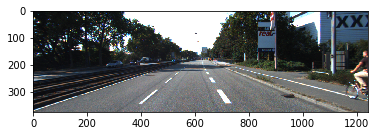

In [20]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [22]:
with model.graph.as_default():
    
            
  config = tf.ConfigProto()
  config.gpu_options.allow_growth = True

  with tf.Session(config=config) as sess:
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files/tmp/'))
    model.saver.restore(sess, tf.train.latest_checkpoint('../training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_to_resume/tmp/'))
#     model.saver.restore(sess, tf.train.latest_checkpoint('../training_files_archive/training_files_3/tmp/'))
    dataset = data_generator(base_path, i_c, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths)
   
    i = 0
    if True:

      feed_dict = prepare_dataset_feed_dict_2(model, dataset, False)
      feed_dict[model.weight_cls] = 1
      feed_dict[model.weight_loc] = 1
      feed_dict[model.weight_dim] = 1
      feed_dict[model.weight_theta] = 1
   

      final_output, cls_loss, loc_loss, dim_loss, theta_loss,\
                        reg_loss, iou, iou_2d, iou_dim, iou_loc,\
                        precision, recall, theta_accuracy,\
                    debug_layers, cnn_lidar_resgroups= sess.run([model.final_output,\
                                                              model.classification_loss, model.loc_reg_loss, model.dim_reg_loss, model.theta_reg_loss,\
                                                              model.regression_loss,\
                                                             model.iou, model.iou_2d, model.iou_dim, model.iou_loc,\
                                                             model.precision, model.recall,\
                                                              model.theta_accuracy, model.debug_layers, model.cnn_lidar.res_groups2 ],\
                                                             feed_dict=feed_dict) 

INFO:tensorflow:Restoring parameters from ../training_files/tmp/model.ckpt-0


KeyboardInterrupt: 

In [ ]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

In [98]:
cls_loss, loc_loss, dim_loss, theta_loss, theta_accuracy, reg_loss, iou, iou_2d, iou_dim, iou_loc, precision, recall

(0.3879139,
 0.016095571,
 0.044192538,
 0.009973217,
 12.517654,
 0.76152325,
 0.76074183,
 0.78938186,
 0.79135084,
 0.8386582,
 0.0,
 0.0)

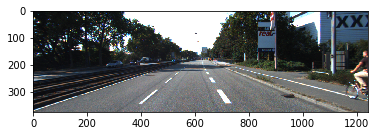

In [99]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [100]:


rot, tr, sc, image_translate_x, image_translate_y, ang, fliplr = get_augmentation_parameters(False)

data_reader_obj = DataReader(list_camera_paths[i_c],
                             list_calib_paths[i_c], 
                             list_label_paths[i_c], 
                             list_lidar_paths[i_c], 
                             rot, sc, tr, ang, image_translate_x, image_translate_y, 
                             get_actual_dims=True, 
                             fliplr=fliplr)
# data_reader_obj.label_reader = LabelReader2(list_label_paths[i_c], list_calib_paths[i_c], rot, tr, sc, ang, data_reader_obj.calib_reader,
#                     get_actual_dims=True, 
#                     from_file=True, fliplr=fliplr)
data_reader_obj.lidar_reader.size = (448//4, 512//4, 35)
# data_reader_obj.label_reader.size = (448, 512, 100)
data_reader_obj.lidar_reader.interpolate = True
camera_image = data_reader_obj.read_image()
lidar_image = data_reader_obj.lidar_reader.read_lidar()
_, label, directions = data_reader_obj.label_reader.read_label()


label2 = get_target(label, directions, anchors=np.array([3.9, 1.6, 1.5]))

(112, 128)
50.87119169784335 39.52111206859787 6.358366934711236 2.793844242258592 -89.954406
30.399644053527382 39.23165512322032 5.406996802181471 2.857337292908541 -90.527364



<Figure size 432x288 with 0 Axes>

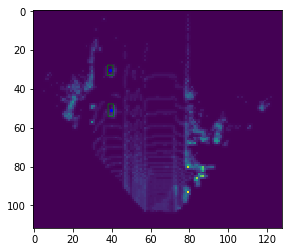

In [101]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 0:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    plt.scatter(y, x, s=5, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, (-label[i][6]*57.2958))
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


39.52111206859787 26.900505029407775 50.87119169784335
6.358366934711236 2.793844242258592 14.472688515770312
39.23165512322032 26.25124613672834 30.399644053527382
5.406996802181471 2.857337292908541 13.40423500118324



<Figure size 432x288 with 0 Axes>

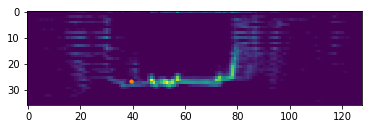

In [102]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z, s=10)
    a = label[i][6]

    print(y, z, x)
    print(l, w, h)
    rect = patches.Rectangle((y-w/2, z-w),w, -h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
print()

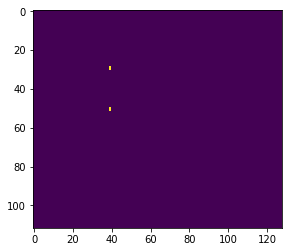

In [103]:
plt.imshow(sigmoid(final_output[0, :, :, 1, -1])>0.2)

In [104]:
def convert_prediction_into_real_values3(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(448, 512), output_size=(112, 128), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
                        
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])

            mins = np.array([-0.5, -0.5, 0, 0.8, 0.3, 0.13, -1.1, -1.1])
            maxs = np.array([0.5, 0.5, 1, 2.6, 1.4, 0.82, 1.1, 1.1])

            out[3:6] = ((np.tanh(out[3:6]) + 1) / 2) * (maxs[3:6] - mins[3:6]) + mins[3:6]

            out[3:6] = np.exp(out[3:6])

            out[:3] = sigmoid(out[:3]) - 0.5 + anchor[:3]

            out[2] = out[2] * 35
        
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)

            result.append(out)
#             print('---')
            
    return np.array(result)

In [105]:
def get_points2(converted_points, calib_path, 
                x_range=(0, 70), y_range=(-40, 40), z_range=(-2.5, 1), 
                size=(448//4, 512//4, 35), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size          


            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])

            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))

            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]

            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

39.52111206859787 50.87119169784335 6.358366934711236 2.793844242258592 -89.954406
39.23165512322032 30.399644053527382 5.406996802181471 2.857337292908541 -90.527364

39.34253845864525 30.347997932103183 6.132604865581388 2.4193782872155083 -105.25285442556
39.47043381069845 50.65587825483325 6.628569230880229 2.522615268488704 -100.26422944074



<Figure size 432x288 with 0 Axes>

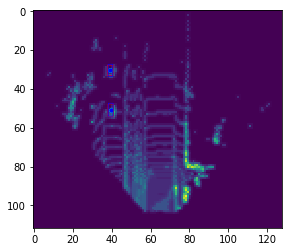

In [117]:
th=0.00001
truth_value = feed_dict[model.y_true][0, :, :, :, :]
converted_points = convert_prediction_into_real_values3(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
points = get_points2(converted_points, list_calib_paths[i_c], th=th)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])


# if True:
#         print('-------------------')
#         labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
#         if len(labels) != len(points):
#             print('not the same')

#         points = np.array(points)
#         points = points[indxes]
#         if len(labels) > 0:
#             selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
#         else:
#             selected_idx = []
# #         print('done', len(selected_idx))
        
#         if len(selected_idx) > 0:
#             points = points[selected_idx]
#             res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#         else:
#             res=""
 
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()


data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)
data_reader_obj.label_reader.size = (448//4, 512//4, 35)
_, label_bev, _ = data_reader_obj.read_label()
data_reader_obj.label_reader.get_actual_dims = True
_, label_bev2, _ = data_reader_obj.read_label()

plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
   
    print(y, x, w, h, -a*57.2958)

    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
        
#     if i == 2:
#         c = 'c'
#     else:
#         c = 'g'

    rect = patches.Polygon(l,linewidth=0.75,edgecolor=c,facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


14.472688515770312 2.793844242258592 6.358366934711236
39.52111206859787 26.900505029407775 50.87119169784335
13.40423500118324 2.857337292908541 5.406996802181471
39.23165512322032 26.25124613672834 30.399644053527382

14.200194016695535 2.4193782872155083 6.132604865581388
39.34253845864525 25.91609567456318 30.347997932103183
14.293692441114297 2.522615268488704 6.628569230880229
39.47043381069845 26.197463700719112 50.65587825483325


<Figure size 432x288 with 0 Axes>

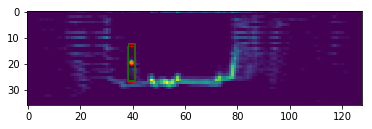

In [118]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10, c='r')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
    print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [119]:
current_file

'000004'

39.52111206859787 50.87119169784335 6.358366934711236 2.793844242258592 -89.954406
39.23165512322032 30.399644053527382 5.406996802181471 2.857337292908541 -90.527364

39.35619888856556 29.693363397594595 6.830041378134477 2.497150250744973 -105.00911236278
39.34253845864525 30.347997932103183 6.132604865581388 2.4193782872155083 -105.25285442556
39.47043381069845 50.65587825483325 6.628569230880229 2.522615268488704 -100.26422944074
39.467141727330855 51.37570406432144 6.311268298563754 2.4847388082439803 -98.16200643168



<Figure size 432x288 with 0 Axes>

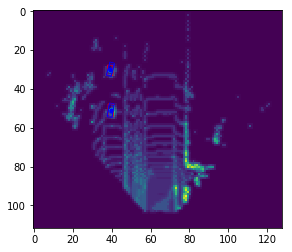

In [122]:
th=0.2
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values3(final_output[0, :, :, :, :], truth_value=truth_value, th=th)
# print(converted_points)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points2(converted_points, list_calib_paths[i_c], th=th)
# print(points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])


# if True:
#         print('-------------------')
#         labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
#         if len(labels) != len(points):
#             print('not the same')

#         points = np.array(points)
#         points = points[indxes]
#         if len(labels) > 0:
#             selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
#         else:
#             selected_idx = []
# #         print('done', len(selected_idx))
        
#         if len(selected_idx) > 0:
#             points = points[selected_idx]
#             res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#         else:
#             res=""
 
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()


data_reader_obj.label_reader = LabelReader('./' + current_file + '.txt', 
                                           list_calib_paths[i_c],
                                           rot, tr, sc, ang, data_reader_obj.calib_reader,
                                        get_actual_dims=True, 
                                        from_file=True, fliplr=fliplr)
data_reader_obj.label_reader.size = (448//4, 512//4, 35)
_, label_bev, _ = data_reader_obj.read_label()
data_reader_obj.label_reader.get_actual_dims = True
_, label_bev2, _ = data_reader_obj.read_label()

plt.clf()
fig,ax = plt.subplots(1)

img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
   
    print(y, x, w, h, -a*57.2958)

    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
        
#     if i == 2:
#         c = 'c'
#     else:
#         c = 'g'

    rect = patches.Polygon(l,linewidth=0.75,edgecolor=c,facecolor='none')
    ax.add_patch(rect)

print()


plt.show()


In [ ]:
current_file

In [111]:
145.04382/4

36.260955

In [112]:
253.43287673793736//4, 251.97153058214832//4

(63.0, 62.0)

In [113]:
226.5721970389598//4

56.0

39.52111206859787 26.900505029407775 50.87119169784335
39.23165512322032 26.25124613672834 30.399644053527382

39.35619888856556 25.48144142236585 29.693363397594595
39.34253845864525 25.91609567456318 30.347997932103183
39.47043381069845 26.197463700719112 50.65587825483325
39.467141727330855 26.052247695773016 51.37570406432144


<Figure size 432x288 with 0 Axes>

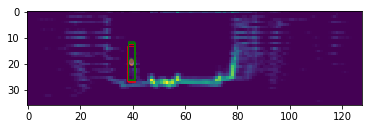

In [114]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


In [115]:
current_file

'000004'

In [116]:
th=0.01
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values(final_output[0, :, :,  :], truth_value=truth_value, th=th)
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)

res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
# print('res', res)
print(len(points))
if True:
        labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
        if len(labels) != len(points):
            print('not the same')

        points = np.array(points)
        points = points[indxes]
        if len(labels) > 0:
            selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
        else:
            selected_idx = []
#         print('done', len(selected_idx))
        
        if len(selected_idx) > 0:
            points = points[selected_idx]
            print(len(points))
            res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
        else:
            res=""
            
   
text_file = open('./' + current_file + '.txt', "wb+")
text_file.write(res.encode())
text_file.close()

all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=True)

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    w = label[i][3]
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
   
    plt.scatter(y, x, s=15, c='c')
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
    print(y, x, w, h, -a*57.2958)
#     print(w, h, a*57.2958
#     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

#     ax.add_patch(rect)
    
    polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
#     if i == 1:
#         break
 
print()

for i in range(0, len(label_bev)):
    w = label_bev[i][3] 
    h = label_bev[i][4] 
    x = label_bev[i][0]
    y = label_bev[i][1]
    print(y, x, w, h, -label_bev[i][6]*57.2958)
    ax.scatter(y, x, s=10, c='b')
    polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for i in range(4):
        l.append([xs[i], ys[i]])

    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
#     break

print()


plt.show()


ValueError: operands could not be broadcast together with shapes (2,9) (3,) 

In [60]:
226.5721970389598 // 4 - 226.5721970389598/4, 225.08346074265836//4 - 225.08346074265836/4

(-0.6430492597399535, -0.27086518566459006)

239.146942751911 45.99406488924987 422.6471127284992
248.9220250435418 43.541518342791825 395.9599946486568
280.7320313671428 48.18069164659401 406.8721717313903
263.2307473287571 40.21279787720802 353.94760109234386
302.6245180722551 33.06654602390264 234.14888554516335
310.5415960687491 44.818466616150936 318.6759265430846



NameError: name 'label_bev' is not defined

<Figure size 432x288 with 0 Axes>

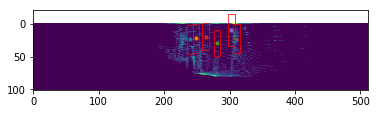

In [61]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    
print()
for i in range(0, len(label_bev)):
    l = label_bev[i][3]
    w = label_bev[i][4] 
    h = label_bev[i][5]
    x = label_bev[i][0]
    y = label_bev[i][1]
    z = label_bev[i][2]
#     print(y, z)
    plt.scatter(y, z-h/2, s=10)
    a = label_bev[i][6]
#     if a < 0:
#       a = a + 3.14
#     print(h, w, l)
    print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h),w, h, angle= 0,linewidth=0.75,edgecolor='g',facecolor='none')

    ax.add_patch(rect)
    
plt.show()


### Visualization

In [62]:
i = 2
j = 5
np.mean(final_output[0, :, :, j])

IndexError: index 5 is out of bounds for axis 3 with size 2

TypeError: Invalid dimensions for image data

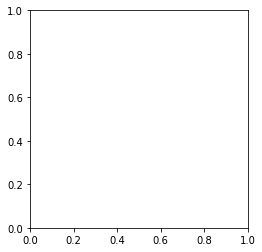

In [63]:
plt.imshow(sigmoid(final_output[0, :, :, -1])>=0.2)

TypeError: Invalid dimensions for image data

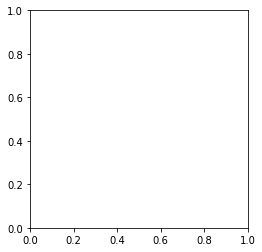

In [64]:
plt.imshow(sigmoid(final_output[0, :, :, -1]))

In [65]:
debug_layers.keys()

dict_keys(['fpn_lidar1_output_post_conv_1_0', 'fpn_lidar2_output_post_conv_1_1', 'final_layer', 'fpn_lidar1_output_post_conv_1_1', 'fpn_lidar2_output_post_conv_1_0'])

In [66]:
debug_layers['fpn_lidar1_output_post_conv_1_1'].shape

(1, 112, 128, 128)

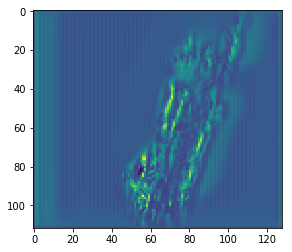

In [67]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

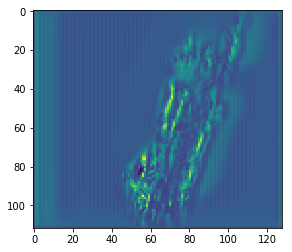

In [68]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

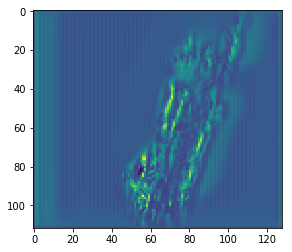

In [69]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

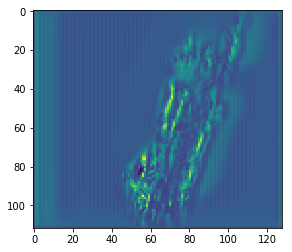

In [70]:
i = 50
plt.imshow(debug_layers['fpn_lidar1_output_post_conv_1_0'][0, :, :, i])

In [71]:
cnn_lidar_resgroups[0].shape

(1, 224, 256, 64)

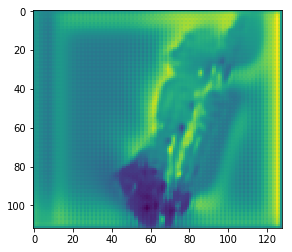

In [72]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])

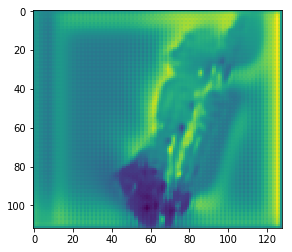

In [73]:
i = 3
j = 33
plt.imshow(cnn_lidar_resgroups[i][0, :, :, j])